<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_2_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tqdm.notebook as nb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import CelebA as DS  #other options CIFAR10, STL10
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from IPython.display import clear_output

In [ ]:
def imshow(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
image_size = 64
batch_size = 64
latent_dim=100

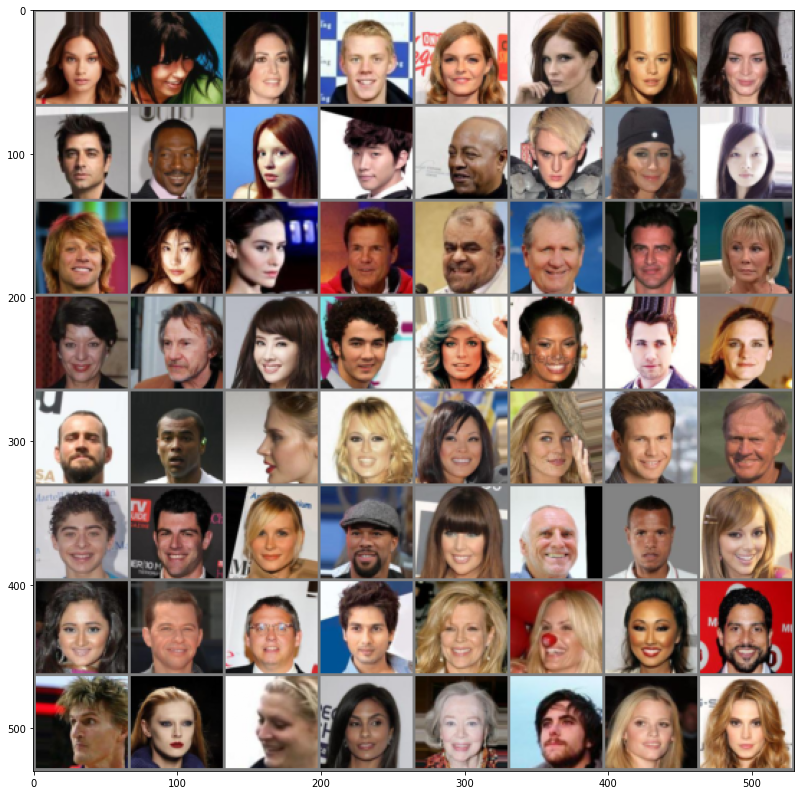

In [ ]:
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

to_image = transforms.ToPILImage()
trainset = DS(root='./data/', download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

device = 'cuda'

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(make_grid(images),14)

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_dim=100, feature_maps=64, channels=3):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d( latent_dim, 
                        feature_maps * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(feature_maps * 8),
    nn.ReLU(True),
    # state size. (ngf*8) x 4 x 4
    nn.ConvTranspose2d(feature_maps * 8, 
                        feature_maps * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(feature_maps * 4),
    nn.ReLU(True),
    # state size. (ngf*4) x 8 x 8
    nn.ConvTranspose2d( feature_maps * 4, 
                        feature_maps * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(feature_maps * 2),
    nn.ReLU(True),
    # state size. (ngf*2) x 16 x 16
    nn.ConvTranspose2d( feature_maps * 2, 
                        feature_maps, 4, 2, 1, bias=False),
    nn.BatchNorm2d(feature_maps),
    nn.ReLU(True),
    # state size. (ngf) x 32 x 32
    nn.ConvTranspose2d( feature_maps, channels, 4, 2, 1, bias=False),
    nn.Tanh()
    # state size. (nc) x 64 x 64
  )

  def forward(self, input):
    return self.main(input)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, feature_maps=64, channels=3):
    super(Discriminator, self).__init__()        
    self.main = nn.Sequential(
    # input is (nc) x 64 x 64
    nn.Conv2d(channels, 
              feature_maps, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf) x 32 x 32
    nn.Conv2d(feature_maps, 
              feature_maps * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(feature_maps * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*2) x 16 x 16
    nn.Conv2d(feature_maps * 2, 
              feature_maps * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(feature_maps * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*4) x 8 x 8
    nn.Conv2d(feature_maps * 4, 
              feature_maps * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(feature_maps * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*8) x 4 x 4
    nn.Conv2d(feature_maps * 8, 1, 4, 1, 0, bias=False),
    nn.Sigmoid()
  )

  def forward(self, input):
    return self.main(input)

In [ ]:
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

g_optim = optim.Adam(generator.parameters(), lr=1e-4)
d_optim = optim.RMSprop(discriminator.parameters(), lr=1e-4)

g_losses = []
d_losses = []

loss_fn = nn.BCELoss()

#def noise(n, n_features=128):
    #return Variable(torch.randn(n, n_features)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    loss_real = loss_fn(prediction_real, make_ones(n))
    loss_real.backward()

    prediction_fake = discriminator(fake_data)
    loss_fake = loss_fn(prediction_fake, make_zeros(n))
    
    loss_fake.backward()
    optimizer.step()
    
    return loss_real + loss_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    loss = loss_fn(prediction, make_ones(n))
    
    loss.backward()
    optimizer.step()
    
    return loss

Epoch 38: g_loss: 4.47832489 d_loss: 0.08757796



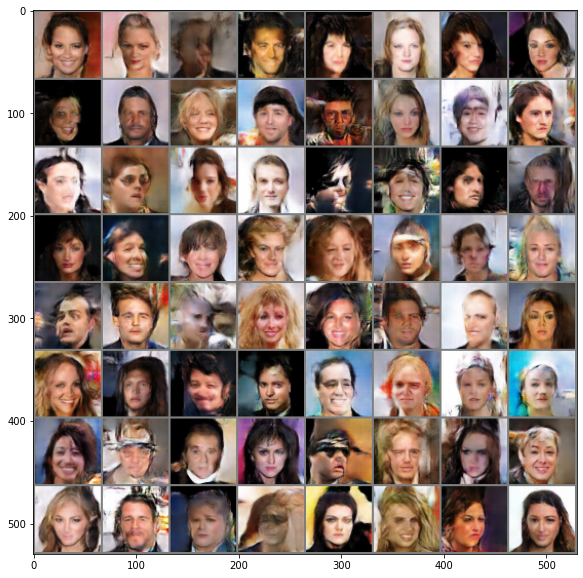

In [ ]:
epochs = 250
num_samples = 1
k = 1
test_noise = torch.randn(64, latent_dim, 1, 1, device=device)

generator.train()
discriminator.train()
for epoch in range(epochs):
    g_loss = 0.0
    d_loss = 0.0
    for i, data in nb.tqdm(enumerate(train_loader),total=num_samples):
        if i > num_samples: break
        imgs, _ = data
        n = len(imgs)        
        for j in range(k):          
            noise = torch.randn(n, latent_dim, 1, 1, device=device)
            fake_data = generator(noise).detach()
            real_data = imgs.to(device)
            d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise)
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()        
    g_losses.append(g_loss/i)
    d_losses.append(d_loss/i)
    clear_output()
    print(f'Epoch {epoch+1}: g_loss: {g_loss/i:.8f} d_loss: {d_loss/i:.8f}')
    imshow(make_grid(img))   

In [ ]:
plt.plot(g_losses, label='Generator_Losses')
plt.plot(d_losses, label='Discriminator Losses')
plt.legend()
plt.show()